# EXTRACCIÓN DE LAS REGLAS

## Fuzzy-CSarAFP

In [294]:
import numpy as np
import pandas as pd
import re

def parse_ruleline(line, attributes, att_types, att_values):
    """
    Parsea la línea que recibe como argumento y, teniendo en cuenta las listas 
    de atributos, tipos de atributos y valores posibles de los atributos
    que también se aportan como argumento, devuelve un vector que contiene:
        - una posición por cada atributo con el valor de dicho atributo
        en el antecedente de la regla (vacío si el atributo no forma parte
        del antecedente)
        - una posición para el nombre del atributo del consecuente
        - una posición para el valor/etiqueta del atributo del consecuente
        - tres posiciones para soporte, confianza y numerosidad de la regla
    """
    
    
    antecedent = np.empty(len(attributes), dtype='U50')
    consequent = np.empty(2, dtype='U50')
    parameters = np.empty(4, dtype=float)
    
    line_splitted = re.split('->', line)
    
    part1 = line_splitted[0]
    part2 = line_splitted[1]
    
    # Antecedente
    ant_vars = re.findall('V\s*\d+\s+\[*\d+\]*', part1)
    
    for ant_var in ant_vars:
        ant_att_id = int(re.findall('\d+', re.findall('V\s*\d+', ant_var)[0])[0]) # Get attribute index)
        ant_lab = re.findall('\[*\d+\]*\s*$', ant_var)[0] # Get value/label
        
        if att_types[ant_att_id] == 'categorical': # If it's categorical we get the true name of the label
            ant_lab = re.sub('\[|\]', '', ant_lab)
            ant_lab = att_values[ant_att_id][int(ant_lab)]#[int(ant_lab)-1]
        antecedent[ant_att_id] = ant_lab
    
    
    # Consecuente
    con_var = re.findall('V\s*\d+\s+\[*\d+\]*', part2)[0]
    
    con_att_id = int(re.findall('\d+', re.findall('V\s*\d+', con_var)[0])[0]) # Get attribute index
    
    con_att = attributes[con_att_id] # Get attribute name
    
    con_lab = re.findall('\[*\d+\]*\s*$', con_var)[0] # Get value/label
    
    if att_types[con_att_id] == 'categorical': # If it's categorical we get the true name of the label
        con_lab = re.sub('\[|\]', '', con_lab)
        con_lab = att_values[con_att_id][int(con_lab)]#[int(con_lab)-1]
    
    consequent[0] = con_att
    consequent[1] = con_lab
    
    # Parámetros
    # Si se quieren utilizar más parámetros solo hay que ampliar el tamaño 
    # del array parameters y asignar las posiciones de params_splitted que correspondan
    params = part2.replace(con_var, '')
    
    params_splitted = re.split('\s+', params)
    
    parameters[0] = float(params_splitted[7])
    parameters[1] = float(params_splitted[8])
    parameters[2] = float(params_splitted[9])
    parameters[3] = int(params_splitted[16])
    
    # Concatenamos antecedente, consecuente y parámetros 
    rule = np.concatenate([antecedent, consequent, parameters])
    return(rule)

In [295]:
from os.path import isfile

def isfile(input_path): # Comprobamos que el archivo existe
    
    input_file = open(input_path, 'r') # Abrimos como archivo sólo de lectura
    reading_rules = False
    n_att = 0    
    
    for line in input_file.readlines(): # Vamos leyendo una a una las líneas del archivo
        if re.match('@attribute', line): # Si la línea comienza con @attribute es una línea con información de un atributo
            attributes.append(re.split('\s+', line)[1]) # Añadimos a attributes el nombre del atributo
            
            if re.search('real', re.split('\s+', line)[2]): # Se trata de un atributo continuo
                att_types.append('real')    
                att_values.append(re.split('\s+', line)[3])
            else:                       # Se trata de un atributo categórico
                att_types.append('categorical') 
                values = re.split('\s+', line)[2]
                values = re.sub('\{|\}', '', values)
                values = re.split(',', values)
                att_values.append(values)
        
        #print(attributes)
        if reading_rules: # Cada línea contiene información de una regla distinta
            new_rule = parse_ruleline(line, attributes, att_types, att_values) # Convertimos la línea en un array
            rules.append(new_rule)
            
        if re.match('Condition ---', line): # Esta línea marca el comienzo de las reglas en el archivo
            reading_rules = True
    
    # Creamos un Data Frame e imprimimos las reglas en un CSV
    rules_df = pd.DataFrame(rules, columns=attributes+['Consequent Attribute', 'Consequent Label', 'Support', 'Confidence','LIFT', 'Numerosity'])
    rules_df.to_csv(re.sub('\.plt', '.csv', input_path), index=False, sep=';')

In [ ]:
for i in range(487,4870+487,487):
    input_path = './FuzzyCSarAFP_TFM_twitter/output/usa_rules_stad.S-10097.'+str(i)+'.Experienced.Reduced.plt'
    attributes = []
    att_types = []
    att_values = []
    rules = []
    isfile(input_path)

In [184]:
def namesInCells(df):
    for column in df:
        if column != "Date":
            df[column][df[column].isnull() == False] = column
    return df

In [185]:
def rowsAsList(df):
    final_l=[]
    for index, row in df.iterrows():
        item_l=[str(item).replace("\'","") for item in row.values.tolist() if str(item) != 'nan']
        final_l.append(list(item_l))
    return final_l

In [186]:
def stringAntecedent(ant_list):
    new_ant_list="+".join(ant_list)
    return "\'"+new_ant_list+"\'"

In [497]:
fcsar_numvalidrules=[]
for i in range(487,4870+487,487):
    input_path = './USA_FuzzyCSar/USA_Fuzzy_Rules/usa_rules_stad.S-10097.'+str(i)+'.Experienced.Reduced.csv'
    df=pd.read_csv(input_path,sep=";")
    new_df=pd.DataFrame()
    new_df["Consecuent"]=df["Consequent Label"].astype(str)
    new_df["Support"]=df["Support"]
    new_df["Confidence"]=df["Confidence"]
    new_df["LIFT"]=df["LIFT"]
    new_df["Numerosity"]=df["Numerosity"]
    copy_df=df[:]
    copy_df=copy_df.drop(["Consequent Attribute","Consequent Label","Support","Confidence","LIFT","Numerosity"],axis=1)
    list_ant=rowsAsList(namesInCells(copy_df))
    new_df["Antecedent_Set"]=list_ant
    new_df["Antecedent_String"] = new_df["Antecedent_Set"].map(stringAntecedent).astype(str)
    new_df.to_csv('./USA_FuzzyCSar/All_Rules/usa_rules_stad'+str(i)+'_Experienced_Reduced.csv')
    new_df = new_df[new_df["LIFT"] >= 1.2]
    num_rules = new_df['Numerosity'].sum()
    fcsar_numvalidrules.append(len(new_df))
    new_df.to_csv('./USA_FuzzyCSar/usa_rules_stad'+str(i)+'_Experienced_Reduced.csv')
    

/Users/pj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/pj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/pj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/pj/anaconda3

KeyboardInterrupt: 

In [507]:
    input_path = './USA_FuzzyCSar/usa_rules_stad'+str(4870)+'_Experienced_Reduced.csv'
    df=pd.read_csv(input_path,sep=",")
    df.sort_values(by=['LIFT', 'Support'],ascending=False,inplace=True)
    df.head(100)

,Unnamed: 0,Consecuent,Support,Confidence,LIFT,Numerosity,Antecedent_Set,Antecedent_String
19,78,'neither',0.010,0.224,3.348,11.0,"['Morning', 'climate_change']",'Morning+climate_change'
2,19,'neither',0.027,0.188,2.792,80.0,['climate_change'],'climate_change'
17,73,'neither',0.010,0.182,2.705,15.0,"['Night', 'climate_change']",'Night+climate_change'
18,77,'neither',0.008,0.174,2.588,11.0,"['Afternoon', 'climate_change']",'Afternoon+climate_change'
12,50,'positive',0.031,0.620,1.981,36.0,"['Afternoon', 'atheism']",'Afternoon+atheism'
9,44,'positive',0.038,0.609,1.944,47.0,"['Night', 'atheism']",'Night+atheism'
6,30,'positive',0.019,0.565,1.933,34.0,['catholic'],'catholic'
1,4,'positive',0.090,0.597,1.908,190.0,['atheism'],'atheism'
13,63,'positive',0.023,0.547,1.741,20.0,"['Morning', 'atheism']",'Morning+atheism'
22,87,'negative',0.011,0.883,1.418,5.0,"['Afternoon', 'feminism', 'man']",'Afternoon+feminism+man'


In [464]:
fcsar_numvalidrules

[3, 10, 11, 14, 18, 16, 17, 21, 23, 23]

In [467]:
def joinAntecedent(ant_list):
    return "+".join(ant_list)

In [466]:
#Rules plot
#for i in range(487,4870+487,487):
#    input_path = './USA_FuzzyCSar/usa_rules_stad'+str(i)+'_Experienced_Reduced.csv'
#    dfff=pd.read_csv(input_path,converters={"Consecuent":eval,"Antecedent_Set":eval,"LIFT":eval})
#    dfff= dfff.drop(["Unnamed: 0","Support","Confidence","Antecedent_String"],axis=1)
#    dfff.Antecedent=dfff.Antecedent.map(joinAntecedent)
#    dfmatrix_rules=dfff.pivot(index = 'Antecedent', columns = 'Consequent',values="LIFT").fillna(0)
#    if 'neither' not in dfmatrix_rules:
#        dfmatrix_rules['neither'] = 0.0
#    dfmatrix_rules.index.name = None
#    dfmatrix_rules.index = [x[:1].upper()+x[1:] for x in dfmatrix_rules.index]
#    dfmatrix_rules.reindex(sorted(dfmatrix_rules.index))
#    dfmatrix_rules.sort_index(axis=0, inplace=True,ascending=False) 
#    dfmatrix_rules.reindex(sorted(dfmatrix_rules.columns))
#    dfmatrix_rules.sort_index(axis=1, inplace=True,ascending=False)
#    dfmatrix_rules.to_csv('./USA_IncMine/usa_rules'+str(i)+'_Matrix.csv')

In [468]:
not_att=["Morning","Afternoon","Night"]
sent=["positive","negative","neither"]
for i in range(487,4870+487,487):
    input_path = './USA_FuzzyCSar/usa_rules_stad'+str(i)+'_Experienced_Reduced.csv'
    dfff=pd.read_csv(input_path,converters={"Consecuent":eval,"Antecedent_Set":eval,"LIFT":eval})
    df_antec=dfff.Antecedent_Set.tolist()
    ants=list(set(x for l in df_antec for x in l))
    interest_ants = [item for item in ants if item not in not_att]
    ellist=[]
    sentlist=[]
    vallist=[]
    for el in interest_ants:
        for s in sent:
            val=0.0
            for idx,rows in dfff.iterrows():
            #print(rows.Antecedent_Set, rows.Consecuent,len(rows.Antecedent_Set))
                if el in rows.Antecedent_Set and s in rows.Consecuent:
                    val+=1.0/len(rows.Antecedent_Set)
            ellist.append(el.capitalize())
            sentlist.append(s.capitalize())
            vallist.append(val)

    df_try = pd.DataFrame()
    df_try["Elemento"] = ellist
    df_try["Sentimiento"] = sentlist
    df_try["Valor"] = vallist
    df_rul = df_try[df_try.Valor != 0.0]
    df_rul.to_csv("./USA_FuzzyCSar/usa_rules_count"+str(i)+'.csv')    
    dfmatrix_rules=df_rul.pivot(index = 'Elemento', columns = 'Sentimiento',values="Valor").fillna(0)
    if 'Neither' not in dfmatrix_rules:
        dfmatrix_rules['neither'] = 0.0
    dfmatrix_rules.index.name = None
    dfmatrix_rules.reindex(sorted(dfmatrix_rules.index))
    dfmatrix_rules.sort_index(axis=0, inplace=True,ascending=False) 
    dfmatrix_rules.reindex(sorted(dfmatrix_rules.columns))
    dfmatrix_rules.sort_index(axis=1, inplace=True,ascending=False)
    dfmatrix_rules.to_csv('./USA_FuzzyCSar/usa_rules_count'+str(i)+'_Matrix.csv')
    

## IncMine

In [469]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 5000)

In [470]:
df_usa = pd.read_csv('./usa_incmine.csv',converters={'BOW_Tweet': eval,'IncM_Tweet': eval,'Keys_Tweet':eval})
del df_usa["Unnamed: 0"]
del df_usa["TransaccionNumber"]
df_usa.head(100)

,Date,BOW_Tweet,Sentiment,IncM_Tweet,Keys_Tweet,Zaki_Tweet
0,Afternoon,[hillary_clinton],negative,"[hillary_clinton, negative, Afternoon]","[22, 2, 54]",1 1 3 22 2 54
1,Afternoon,"[woman, hillary_clinton]",positive,"[woman, hillary_clinton, positive, Afternoon]","[18, 22, 1, 54]",2 2 4 18 22 1 54
2,Afternoon,"[woman, hillary_clinton]",positive,"[woman, hillary_clinton, positive, Afternoon]","[18, 22, 1, 54]",3 3 4 18 22 1 54
3,Afternoon,"[liberal, hillary_clinton]",negative,"[liberal, hillary_clinton, negative, Afternoon]","[39, 22, 2, 54]",4 4 4 39 22 2 54
4,Afternoon,[hillary_clinton],positive,"[hillary_clinton, positive, Afternoon]","[22, 1, 54]",5 5 3 22 1 54
5,Afternoon,"[immigrant, hillary_clinton]",negative,"[immigrant, hillary_clinton, negative, Afternoon]","[33, 22, 2, 54]",6 6 4 33 22 2 54
6,Afternoon,"[man, feminism]",negative,"[man, feminism, negative, Afternoon]","[12, 28, 2, 54]",7 7 4 12 28 2 54
7,Afternoon,[hillary_clinton],negative,"[hillary_clinton, negative, Afternoon]","[22, 2, 54]",8 8 3 22 2 54
8,Afternoon,[atheism],positive,"[atheism, positive, Afternoon]","[44, 1, 54]",9 9 3 44 1 54
9,Afternoon,"[atheism, child]",positive,"[atheism, child, positive, Afternoon]","[44, 48, 1, 54]",10 10 4 44 48 1 54


##### FCIs por Batch

In [471]:
import pandas as pd
filename="./usa_incmine_fcis.txt" #Example

lines_as_list = [line.rstrip('\n') for line in open(filename)]
stream_fci=[]
stream_items=[]
stream_freqs=[]
dic_items = {}
dic_freqs = {}

#Frecuencia de aparición de cada FCI en cada batch(ventana deslizante)
#Aunque algunos aparecen como 0, en realidad en estos casos sí hay apariciones, pero menores a un cierto valor umbral
#Estas se descartan y se toman como 0 debido a la función MST
for i,line in enumerate(lines_as_list):
    splited_line = line.split("\t")
    itemset_line = [int(item) for item in splited_line[0].replace("[","").replace("]","").split(", ")]
    freqs_line = list(map(int, splited_line[1].split(",")))
    stream_items.append(itemset_line)                         #Itemsets frecuentes
    stream_freqs.append(freqs_line)                           #Frecuencias de itemsets en las ventanas
    dic_items["FCI_"+str(i)] = itemset_line
    dic_freqs["FCI_"+str(i)] = freqs_line[::-1]

df_inc = pd.DataFrame(dic_freqs) 
df_inc.head(10)

,FCI_0,FCI_1,FCI_2,FCI_3,FCI_4,FCI_5,FCI_6,FCI_7,FCI_8,FCI_9,...,FCI_181,FCI_182,FCI_183,FCI_184,FCI_185,FCI_186,FCI_187,FCI_188,FCI_189,FCI_190
0,0,0,0,3,0,0,6,4,0,0,...,0,0,0,16,12,4,2,0,0,0
1,0,0,3,0,0,2,0,0,2,0,...,0,4,0,21,11,3,0,0,0,0
2,0,0,0,0,4,0,0,0,0,0,...,4,4,64,11,32,2,0,2,0,0
3,0,0,0,3,0,0,2,2,0,4,...,0,7,0,17,22,3,0,0,0,0
4,0,0,2,0,0,2,0,0,2,0,...,0,2,0,23,20,3,0,0,0,2
5,0,0,4,0,0,0,0,0,0,0,...,0,7,20,28,12,6,3,3,0,0
6,2,0,0,4,3,0,0,0,0,3,...,5,7,35,13,15,6,0,0,0,0
7,0,2,6,0,0,0,0,0,2,0,...,3,5,5,14,5,7,0,0,2,2
8,2,0,0,2,0,0,0,0,0,4,...,0,8,17,17,12,0,0,0,0,3
9,0,0,0,0,0,0,0,0,3,0,...,0,2,28,34,7,4,0,0,0,0


In [472]:
#Funcion para obtener aquellas combinaciones de un itemset de tamaño mayor a 1
from itertools import combinations
def sub_lists(my_list):
    subs = []
    for i in range(0, len(my_list)+1):
        temp = [list(x) for x in combinations(my_list, i) if x and len(x) in [len(my_list),len(my_list)-1,1] ]
        if len(temp)>0:
            subs.extend(temp)
    return subs

In [473]:
#Funcion para obtener aquellas combinaciones de un itemset de tamaño mayor a 1
from itertools import combinations
def sub_rules(my_list):
    subs = []
    for i in range(0, len(my_list)+1):
        temp = [list(x) for x in combinations(my_list, i) if len(x)==len(my_list)-1] #REGLAS SOLO CON 1 CONSECUENTE!
        if len(temp)>0:
            subs.extend(temp)
    return subs

##### Batchs de datos

In [474]:
#1)Generación de los conjuntos-batch con el DF de transacciones
import itertools
lenghtwindow=90
series=[]
for k in list(range(487,len(df_usa.index),487))+[len(df_usa.index)]:
    series.append(df_usa["Keys_Tweet"].iloc[range(k-lenghtwindow,k)].tolist())
    print(k-lenghtwindow,k)

397 487
884 974
1371 1461
1858 1948
2345 2435
2832 2922
3319 3409
3806 3896
4293 4383
4780 4870


##### FCIs por Batch

In [475]:
#2)Extracción los itemsets frecuentes en cada batch (Aquellos que IncMine toma como no-nulos)
batch_fci = []
for index, row in df_inc.iterrows():
    filtered_row = row[row>0]
    batch_fci.append(filtered_row.index.tolist())

##### Diccionario de Soportes por Batch

In [476]:
#3)Extracción los soportes de los itemsets frecuentes en cada batch
def support(item_rule, series_batch):   #valido tanto para itemsets como para reglas
    itemrule_support=0
    for set_data in series_batch:
        if all(item in set_data for item in item_rule)== True:
            itemrule_support+=1
    return itemrule_support/len(series_batch)

In [477]:
support_batchs={}
for i,batch in enumerate(series):  #batch:conjunto de datos en los que analizar el soporte
    fcis=batch_fci[i]   #conjunto fci's encontrados para dicho batch
    dic_support_batch={}
    list_of_itemsets=[]
    for itemset in fcis:
        fci_set=dic_items[itemset]
        for sub_itemset in sub_lists(fci_set):
            list_of_itemsets.append(sub_itemset)
    item_fcis = [list(x) for x in set(tuple(x) for x in list_of_itemsets)]
    for itemset in item_fcis:
        dic_support_batch[str(itemset)]=support(itemset,batch)
    support_batchs["Batch_"+str(i)]=dic_support_batch

##### Filtrando los FCIs que son FalsePositives

In [478]:
#4)Chequeamos que en cada batch el FCI no es un False+: Todos los subFCIs deben serlo también
filtered_batch_fci=[]
for i,batch in enumerate(series):  #batch:conjunto de datos en los que analizar el soporte
    fcis=batch_fci[i]   #conjunto fci's encontrados para dicho batch
    batchsup_dic = support_batchs["Batch_"+str(i)]
    real_fci_batch=[]
    for itemset in fcis:
        if all(batchsup_dic[str(sub_item)] > 0.0 for sub_item in sub_lists(dic_items[itemset])):
            real_fci_batch.append(itemset)
    filtered_batch_fci.append(real_fci_batch)

##### Generacion de Reglas

In [479]:
rules_batchs={}
for i,b_dic in enumerate(support_batchs):
    fcis_set = filtered_batch_fci[i]
    batch_supports_set = support_batchs[b_dic]
    confidence_df=pd.DataFrame()
    itmst=[]
    ant=[]
    cons=[]
    conf=[]
    sup=[]
    supA=[]
    supC=[]
    for items in fcis_set: #aqui coge elementos del conjunto de itemsets del batch-X
        #items = literal_eval(itemset)
        itemset=dic_items[str(items)]
        if len(itemset) != 1:
            for sub_items in sub_rules(itemset):
                conseq_item= [item for item in itemset if item not in sub_items]
                itmst.append(itemset)
                ant.append(sub_items)
                cons.append(conseq_item)
                conf.append(batch_supports_set[str(itemset)]/batch_supports_set[str(sub_items)])
                sup.append(batch_supports_set[str(itemset)])
                supA.append(batch_supports_set[str(sub_items)])
                supC.append(batch_supports_set[str(conseq_item)])   
    confidence_df["Itemset"] = itmst
    confidence_df["Antecedent"] = ant
    confidence_df["Consequent"] = cons
    confidence_df["Supp_A"] = supA
    confidence_df["Supp_C"] = supC
    confidence_df["Supp"] = sup
    confidence_df["Conf"] = conf
    #confidence_df.append({"Itemset":itmst,"Antecedent":ant,"Consequent":cons,"Supp_A":supA,"Supp_C":supC,"Supp":sup,"Conf":conf},ignore_index=True)
    rules_batchs[b_dic]=confidence_df

##### LIFT + Leverage

In [480]:
#5)Calculo del LIFT y Leverage de reglas obtenidas en cada batch
def lift(rule_conf,sup_conseq):
    return rule_conf/sup_conseq
    
def leverage(sup_rule,sup_conseq,sup_antec):
    return sup_rule-(sup_antec*sup_conseq)

In [481]:
for rule_dic in rules_batchs:
    rules_batchs[rule_dic]['LIFT'] = rules_batchs[rule_dic].apply(lambda x: lift(x["Conf"],x["Supp_C"]), axis=1)
    rules_batchs[rule_dic]['Leverage'] = rules_batchs[rule_dic].apply(lambda x: leverage(x["Supp"],x["Supp_C"],x["Supp_A"]), axis=1)  

##### Filtrado por LIFT

In [482]:
rules_liftlev= {}
for batch in rules_batchs:
    rules_df_liftlev=rules_batchs[batch][rules_batchs[batch]["LIFT"]>1.2]
    rules_liftlev[batch]=rules_df_liftlev

##### From Keys to Values

In [483]:
import json
with open('./dics_usa/usa_keysTOwords.json') as f:
    dictionary = json.load(f)

In [484]:
def stringAntecedent(ant_list):
    new_ant_list="+".join(ant_list)
    return "\'"+new_ant_list+"\'"

In [485]:
final_batch={}
incm_numvalidrules=[]
for i,b_dic in enumerate(rules_liftlev):
    new_df = rules_liftlev[b_dic]
    new_df["Itemset"]=new_df["Itemset"].map(lambda x: [dictionary[str(item)].replace("-","_") for item in x])
    new_df["Antecedent"]=new_df["Antecedent"].map(lambda x: [dictionary[str(item)].replace("-","_") for item in x])
    new_df["Consequent"]=new_df["Consequent"].map(lambda x: [dictionary[str(item)] for item in x])
    new_df["Consequent"]=new_df["Consequent"].map(lambda x: x[0].replace("-","_"))
    new_df["Antecedent_String"] = new_df["Antecedent"].map(stringAntecedent).astype(str)
    new_df["Antecedent_String"] = new_df["Antecedent_String"].str.replace("-","_")
    new_df.to_csv("./USA_IncMine/all_rules/usa_incmine_batch_"+str(i)+'.csv')
    
# Only rules with Sentiment as Consequent
    new_df=new_df[new_df["Consequent"].isin(["negative","neither","positive"])] #neutral
    incm_numvalidrules.append(len(new_df))
    final_batch[b_dic] = new_df

/Users/pj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/pj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/pj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

In [513]:
incm_numvalidrules

[14, 11, 14, 19, 13, 15, 10, 13, 14, 26]

In [487]:
for i,batch_name in enumerate(final_batch):
    final_batch[batch_name].to_csv("./USA_IncMine/usa_incmine_batch_"+str(i)+'.csv')

In [ ]:
not_att=["Morning","Afternoon","Night"]
sent=["positive","negative","neither"]
for i in range(0,10):
    input_path = './USA_IncMine/usa_incmine_batch_'+str(i)+'.csv' 
    dfff=pd.read_csv(input_path,converters={"Antecedent":eval,"LIFT":eval})
    df_antec=dfff.Antecedent.tolist()
    ants=list(set(x for l in df_antec for x in l))
    interest_ants = [item for item in ants if item not in not_att]
    ellist=[]
    sentlist=[]
    vallist=[]
    for el in interest_ants:
        for s in sent:
            val=0.0
            for idx,rows in dfff.iterrows():
                if el in rows.Antecedent and s in rows.Consequent:
                    val+=1.0/len(rows.Antecedent)
            ellist.append(el.capitalize())
            sentlist.append(s.capitalize())
            vallist.append(val)

    df_try = pd.DataFrame()
    df_try["Elemento"] = ellist
    df_try["Sentimiento"] = sentlist
    df_try["Valor"] = vallist
    df_rul = df_try[df_try.Valor != 0.0]
    df_rul.to_csv("./USA_IncMine/usa_rules_count"+str(i)+'.csv')
    dfmatrix_rules=df_rul.pivot(index = 'Elemento', columns = 'Sentimiento',values="Valor").fillna(0)
    if 'Neither' not in dfmatrix_rules:
        dfmatrix_rules['neither'] = 0.0
    dfmatrix_rules.index.name = None
    dfmatrix_rules.reindex(sorted(dfmatrix_rules.index))
    dfmatrix_rules.sort_index(axis=0, inplace=True,ascending=False) 
    dfmatrix_rules.reindex(sorted(dfmatrix_rules.columns))
    dfmatrix_rules.sort_index(axis=1, inplace=True,ascending=False)
    dfmatrix_rules.to_csv('./USA_IncMine/usa_rules_count'+str(i)+'_Matrix.csv')

In [489]:
def joinAntecedent(ant_list):
    return "+".join(ant_list)

In [270]:
#Rules plot
#for i in range(0,10):
#    input_path = "./USA_IncMine/usa_incmine_batch_"+str(i)+'.csv'
#    dfff=pd.read_csv(input_path,converters={"Consecuent":eval,"Antecedent":eval})
#    dfff= dfff.drop(["Unnamed: 0","Itemset","Supp_A","Supp_C","Supp","Conf","Leverage"],axis=1)
#    dfff.Antecedent=dfff.Antecedent.map(joinAntecedent)
#    dfmatrix_rules=dfff.pivot(index = 'Antecedent', columns = 'Consequent',values="LIFT").fillna(0)
#    if 'neither' not in dfmatrix_rules:
#        dfmatrix_rules['neither'] = 0.0
#    dfmatrix_rules.index.name = None
#    dfmatrix_rules.index = [x[:1].upper()+x[1:] for x in dfmatrix_rules.index]
#    dfmatrix_rules.reindex(sorted(dfmatrix_rules.index))
#    dfmatrix_rules.sort_index(axis=0, inplace=True,ascending=False) 
#    dfmatrix_rules.reindex(sorted(dfmatrix_rules.columns))
#    dfmatrix_rules.sort_index(axis=1, inplace=True,ascending=False)
#    dfmatrix_rules.to_csv('./USA_IncMine/usa_rules'+str(i)+'_Matrix.csv')

In [510]:
final_batch["Batch_9"][["Antecedent_String","Consequent","Supp_A","Supp_C","Supp","Conf","Leverage","LIFT"]].sort_values(by=['LIFT', 'Supp'],ascending=False).head(100)
#.to_latex(index=False)

,Antecedent_String,Consequent,Supp_A,Supp_C,Supp,Conf,Leverage,LIFT
15,'woman+feminism+Night',positive,0.033333,0.355556,0.033333,1.000000,0.021481,2.812500
28,'atheism+Night',positive,0.055556,0.355556,0.044444,0.800000,0.024691,2.250000
111,'atheism',positive,0.144444,0.355556,0.111111,0.769231,0.059753,2.163462
88,'woman+feminism',positive,0.044444,0.355556,0.033333,0.750000,0.017531,2.109375
46,'atheism+Morning',positive,0.066667,0.355556,0.044444,0.666667,0.020741,1.875000
3,'hillary_clinton+donald_trump+Night',negative,0.033333,0.566667,0.033333,1.000000,0.014444,1.764706
85,'hillary_clinton+donald_trump',negative,0.033333,0.566667,0.033333,1.000000,0.014444,1.764706
161,'child',negative,0.033333,0.566667,0.033333,1.000000,0.014444,1.764706
7,'pregnant+abortion+Night',negative,0.022222,0.566667,0.022222,1.000000,0.009630,1.764706
11,'woman+abortion+Night',negative,0.022222,0.566667,0.022222,1.000000,0.009630,1.764706


In [514]:
fcsar_numvalidrules=[3, 10, 11, 14, 18, 16, 17, 21, 23, 23]

### Gráfico evolución número de reglas

<IPython.core.display.Javascript object>


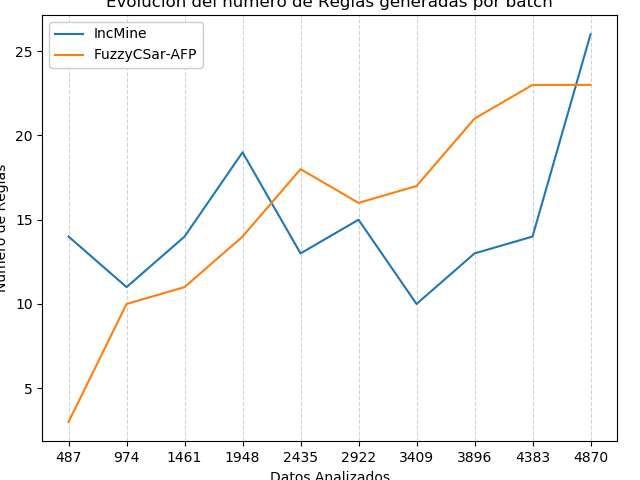

In [515]:
%matplotlib notebook
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt; plt.rcdefaults()
from scipy.interpolate import spline

x = np.linspace(487,4870,10)
y = np.asarray([incm_numvalidrules,fcsar_numvalidrules])


plt.plot(x,incm_numvalidrules,x,fcsar_numvalidrules)

plt.tight_layout()
leg = plt.gca().legend(("IncMine","FuzzyCSar-AFP"),fancybox=True, framealpha=1.0)

#LH = leg.legendHandles
#LH[0].set_color('red')
#LH[1].set_color('sienna')
#LH[2].set_color('mediumpurple')

plt.grid(color='lightgray',axis="x",linestyle='--')
plt.xticks(x) 
plt.xlabel("Datos Analizados")
plt.ylabel("Número de Reglas")
plt.title("Evolución del número de Reglas generadas por batch")
plt.show()
plt.savefig('./Desktop/PDF-TFM/numRules_USA.png',bbox_inches='tight')